In [1]:
using CairoMakie, Dierckx, Optim, LinearAlgebra, QuantEcon

In [2]:
set_theme!(theme_dark())

In [12]:
function create_EGM_model(;nk = 101, nz = 19)

    p = (;α = 0.33, # Capital share
    β = 0.96, # Discount factor
    A = 5, # TFP
    γ = 2.0, # Risk aversion
    δ = 0.08, # Depreciation rate
    nk = nk, # Number of capital gridpoints
    nz = nz, # Number of shock gridpoints
    θ = 4, # Grid expansion parameter
    lb = 10^-4, # Lower bound of capital grid
    ub = 1_000.0, # Upper bound of capital grid
    ρ = 0.9, # Persistence of AR(1) process
    μ = 0.0, # Mean of AR(1) process
    σ = 0.003, # Var of AR(1) process
    toler = 1e-6, # Tolerance
    maxiter = 500, # Maximum number of iterations
    print_skip_pol = 5, # Print every x iterations in policy step
    print_skip_val = 50, # Print every x iterations in value step
    kgrid = LinRange(0.0,1.0,nk), # Capital grid
    zgrid = LinRange(0.0,1.0,nz), # Shock grid
    Π = zeros(Float64, nz, nz)) # Transition matrix

    # Create productivity grid and transition matrix
    mc = rouwenhorst(p.nz, p.μ, p.ρ, p.σ)
    zgrid, Π = exp.(mc.state_values), mc.p

    # Create capital grid
    temp_grid = LinRange(0.0,1.0,p.nk)
    kgrid = p.lb .+ (p.ub - p.lb) * (temp_grid .^ p.θ)

    # Return NamedTuple
    p = (p..., kgrid = kgrid, zgrid = zgrid, Π = Π)

    return p
end

model_EGM = create_EGM_model(nk = 101, nz = 19)

(α = 0.33, β = 0.96, A = 5, γ = 2.0, δ = 0.08, nk = 101, nz = 19, θ = 4, lb = 0.0001, ub = 1000.0, ρ = 0.9, μ = 0.0, σ = 0.003, toler = 1.0e-6, maxiter = 500, print_skip_pol = 5, print_skip_val = 50, kgrid = [0.0001, 0.00010999999900000001, 0.000259999984, 0.0009099999189999999, 0.0026599997439999998, 0.006349999375000002, 0.013059998703999997, 0.02410999759900001, 0.041059995904, 0.065709993439  …  685.7496414250392, 716.3929883607041, 748.0520351947993, 780.7489819251039, 814.5062685493749, 849.3465750653438, 885.2928214707189, 922.3681677631839, 960.596013940399, 1000.0], zgrid = [0.022029416207459813, 0.03367119517536108, 0.0514652487319813, 0.0786628396542, 0.12023340982353327, 0.18377257802212915, 0.2808899829295973, 0.42933055279166177, 0.6562167922043459, 1.003004504503377, 1.5330574407806241, 2.3432248870073975, 3.5815376025930226, 5.474255445950834, 8.367208727845274, 12.78898702966352, 19.54752111066569, 29.877704988334344, 45.66703114508307], Π = [3.814697265625e-6 6.866455

In [8]:
function utility(c)
    if model_EGM.γ == 1.0
        return log(c)
    else
        return (c^(1-model_EGM.γ)-1) / (1-model_EGM.γ)
    end
end 

function marginal_utility(c)
    return c^(-model_EGM.γ)
end

function inverse_marginal_utility(u)
    return u^(-1/model_EGM.γ)
end

function resources(i ,j , p)
    (; α, δ, A, kgrid, zgrid) = p
    return (A * zgrid[j] * (kgrid[i] ^ α)) + (1.0 - δ) * kgrid[i]
end

function marginal_prod(i ,j , p)
    (; α, δ, A, kgrid, zgrid) = p
    return α * A * zgrid[j] * (kgrid[i] ^ (α - 1)) + (1.0 - δ)
end

function initial_guess(p)
    (; nk, nz) = p
    c_pol = zeros(nk, nz)
    for i in 1:nk
        for j in 1:nz
            c_pol[i,j] = 1/2 * resources(i, j, p)
        end
    end
    return c_pol
end

function resource_grid(p)
    (; nk, nz) = p
    Ygrid = zeros(nk, nz)
    for i in 1:nk
        for j in 1:nz
            Ygrid[i,j] = resources(i, j, p)
        end
    end
    return Ygrid
end

function marginal_prod_grid(p)
    (; nk, nz) = p
    MPgrid = zeros(nk, nz)
    for i in 1:nk
        for j in 1:nz
            MPgrid[i,j] = marginal_prod(i, j, p)
        end
    end
    return MPgrid
end

function vals(consumption, p)
    (; nk, nz, β, toler, maxiter, Π, print_skip_val, γ) = p
    v1 = zeros(nk,nz)
    v2 = zeros(nk,nz)
    iter = 0
    error = toler + 1
    if iter == 0
        println("/// Finding Value Functions... ///")
    end
    while error >= toler && iter <= maxiter
        v2 = utility.(consumption) + (β * v1 * Π')
        error = maximum(abs.(v2 - v1)/(1 .+ abs.(v1)))
        v1 = copy(v2)
        if iter % print_skip_val == 0
            println("------------------------------------")
            println("Error at iteration $iter is $error")
        end
        iter += 1
    end
    println("------------------------------------")
    println("/// Found Value Functions ///")
    println("------------------------------------")
    return v1
end

vals (generic function with 1 method)

In [13]:
function egm(p)
    # Unpack parameters
    (; print_skip_pol, toler, maxiter, Π, kgrid, zgrid, nk, nz, β, A, α, δ, lb, ub, γ) = p

    # Initialise matrices
    c_pol_1 = initial_guess(p)
    c_pol_2 = zeros(nk, nz)
    s_pol = zeros(nk, nz)
    g = zeros(nk, nz)
    V1 = zeros(nk, nz)
    V2 = zeros(nk, nz)
    V3 = zeros(nk, nz)
    V4 = zeros(nk, nz)
    v_out = zeros(nk, nz)
    MPgrid = marginal_prod_grid(p)
    Ygrid = resource_grid(p)

    # Create Spline dictionary
    splines = Dict{Int, Spline1D}()

    # Set error and iteration counter
    error = toler + 1
    iter = 0
    if iter == 0
        println("/// Finding Policy Functions... ///")
    end

    while error >= toler && iter <= maxiter
        MUgrid = marginal_utility.(c_pol_1)
        V1 = (β .* MUgrid .* MPgrid)
        V2 = (Π * V1')'
        V3 = inverse_marginal_utility.(V2)
        V4 = kgrid .+ V3
        for j in 1:nz
            g[:,j] = (V4[:,j]./(A*zgrid[j])).^(1/α)
            splines[j] = Spline1D(g[:,j], kgrid, k = 1, bc="extrapolate")
            s_pol[:,j] = splines[j].(kgrid)
        end
        c_pol_2 = Ygrid .- s_pol
        error = maximum(abs.(c_pol_2 - c_pol_1)/(1 .+ abs.(c_pol_1)))
        c_pol_1 = copy(c_pol_2)
        if iter % print_skip_pol == 0
            println("------------------------------------")
            println("Error at iteration $iter is $error")
        end
        iter += 1
    end
    if iter == maxiter
        println("------------------------------------")
        println("Failed to converge after $maxiter iterations")
    else
        println("------------------------------------")
        println("/// Found policy functions ///")
        println("------------------------------------")
    end

    v_out = vals(c_pol_2, p)

    return v_out, s_pol, c_pol_1
end

@time begin 
    v_out, k_pol, c_pol = egm(model_EGM)
end

/// Finding Policy Functions... ///
------------------------------------
Error at iteration 0 is 0.22248176979993894
------------------------------------
Error at iteration 5 is 0.00730929040608868
------------------------------------
Error at iteration 10 is 4.129800696443275e-6
------------------------------------
/// Found policy functions ///
------------------------------------
/// Finding Value Functions... ///
------------------------------------
Error at iteration 0 is 0.2831756003003118
------------------------------------
Error at iteration 50 is 0.0068211025510386165
------------------------------------
Error at iteration 100 is 0.0007889762852131784
------------------------------------
Error at iteration 150 is 0.00010074772204365229
------------------------------------
Error at iteration 200 is 1.3055942308285088e-5
------------------------------------
Error at iteration 250 is 1.6952529882257443e-6
------------------------------------
/// Found Value Functions ///
-------

([-324.2879532745236 -259.81144063629677 … -135.42447117244515 -135.35795454700107; -313.4328799073204 -251.08587185011203 … -130.6311326361451 -130.56649848737786; … ; 24.972304274905486 24.97230479184531 … 24.972813210112417 24.972927907468083; 24.973347794429213 24.97334827697898 … 24.973829511940092 24.973938661144523], [7.503095983526906e-5 0.00012416738126129663 … 2.3958028698821523 3.975357979722281; 7.731932107330196e-5 0.00012887343139674355 … 2.482190946827143 4.1143181041882295; … ; 0.1968657850861085 0.353496273425243 … 715.3831711493785 1112.5697044595718; 0.20118744710389233 0.3606369276463607 … 724.8154811951738 1131.405692285979], [0.005288939796759888 0.008025856246437027 … 4.754473478595358 6.953541686813674; 0.005464302543103688 0.00828782184594445 … 4.896558782333061 7.163790302903489; … ; 884.6136796432775 885.0183915085838 … 1609.0059164883232 1973.14783063824; 920.875210826589 921.2846003323251 … 1655.0647883716972 2019.9704379901927])

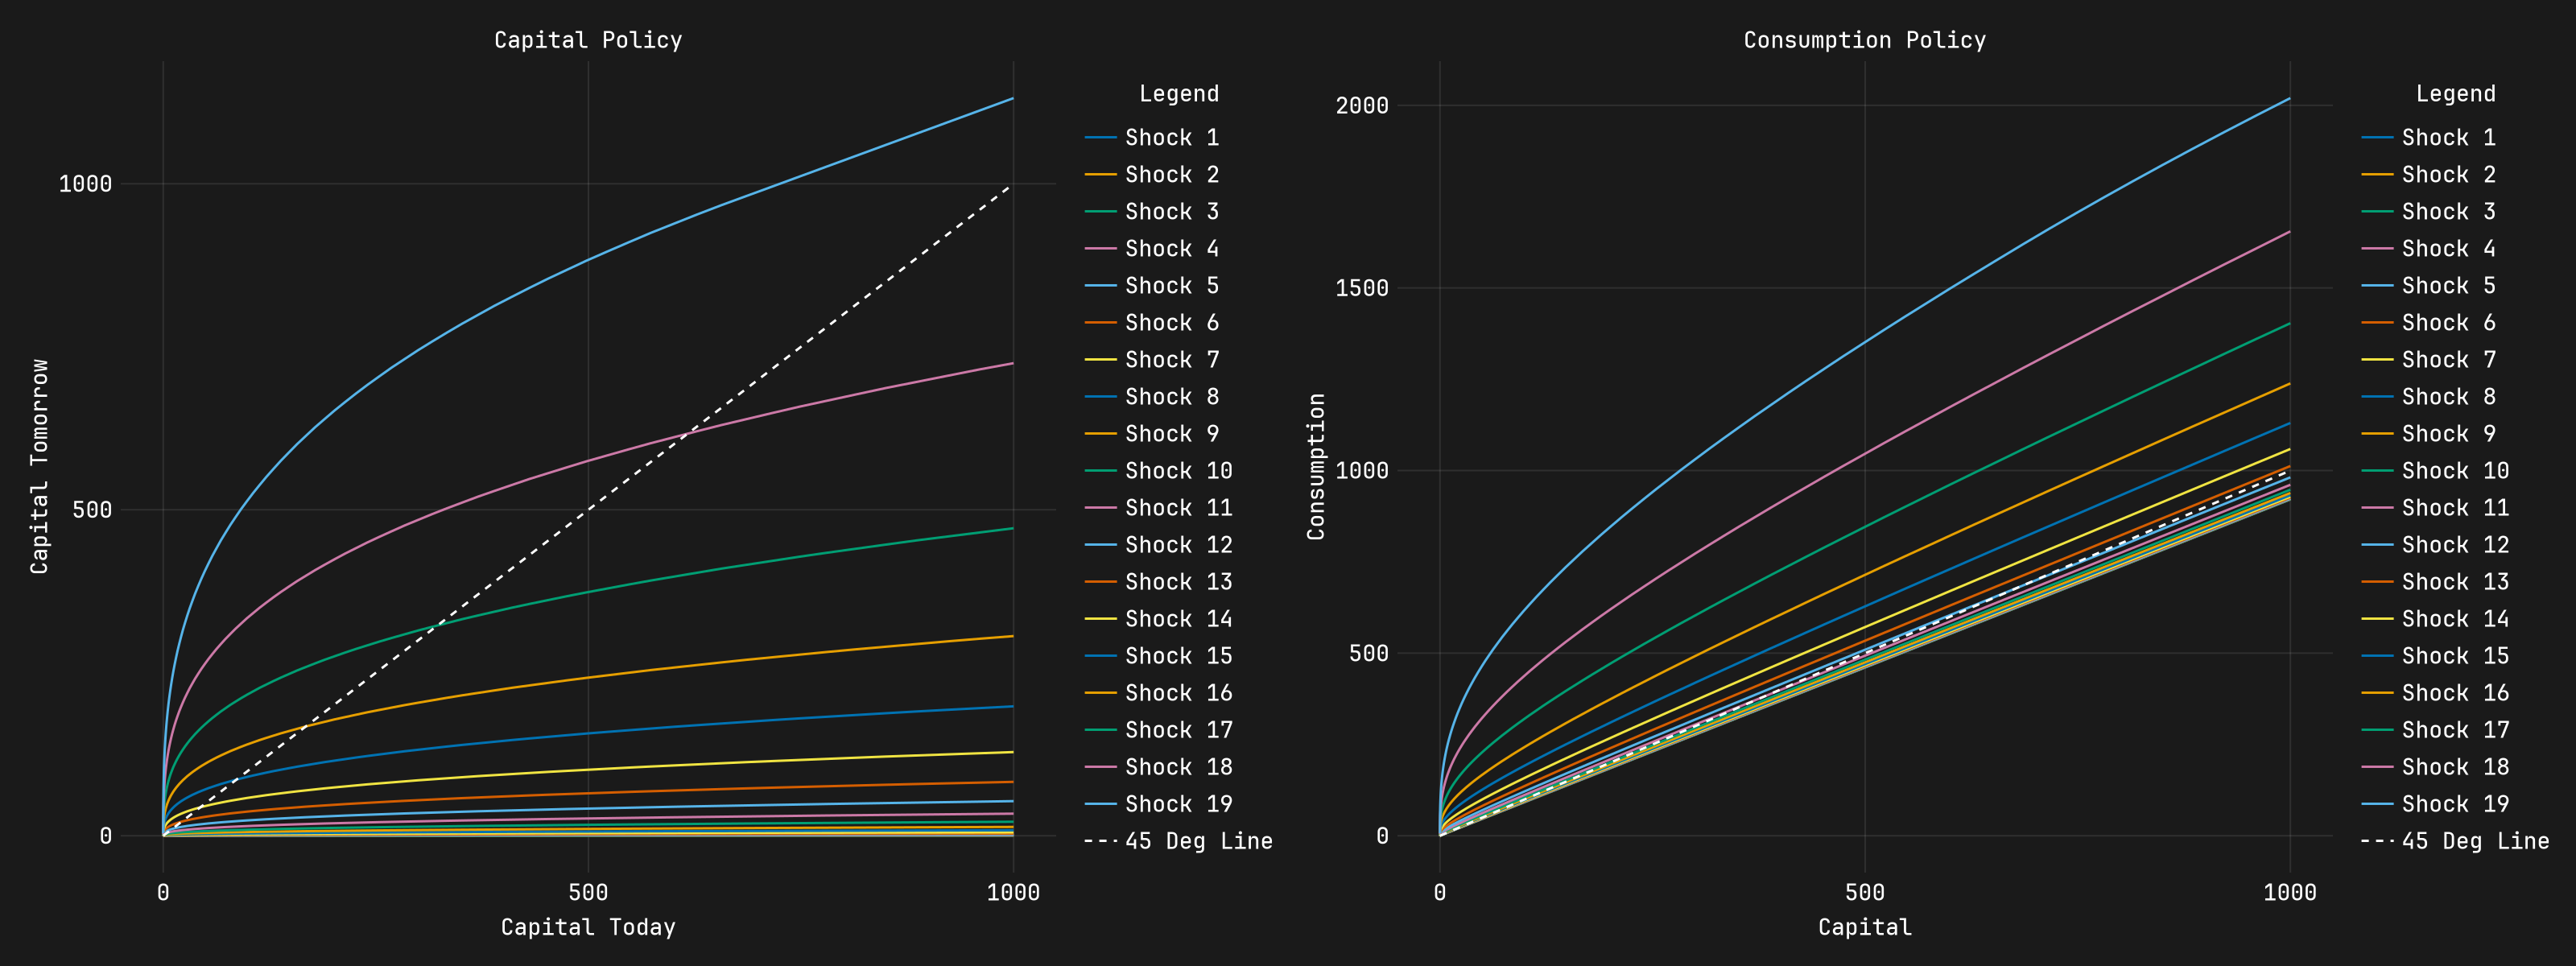

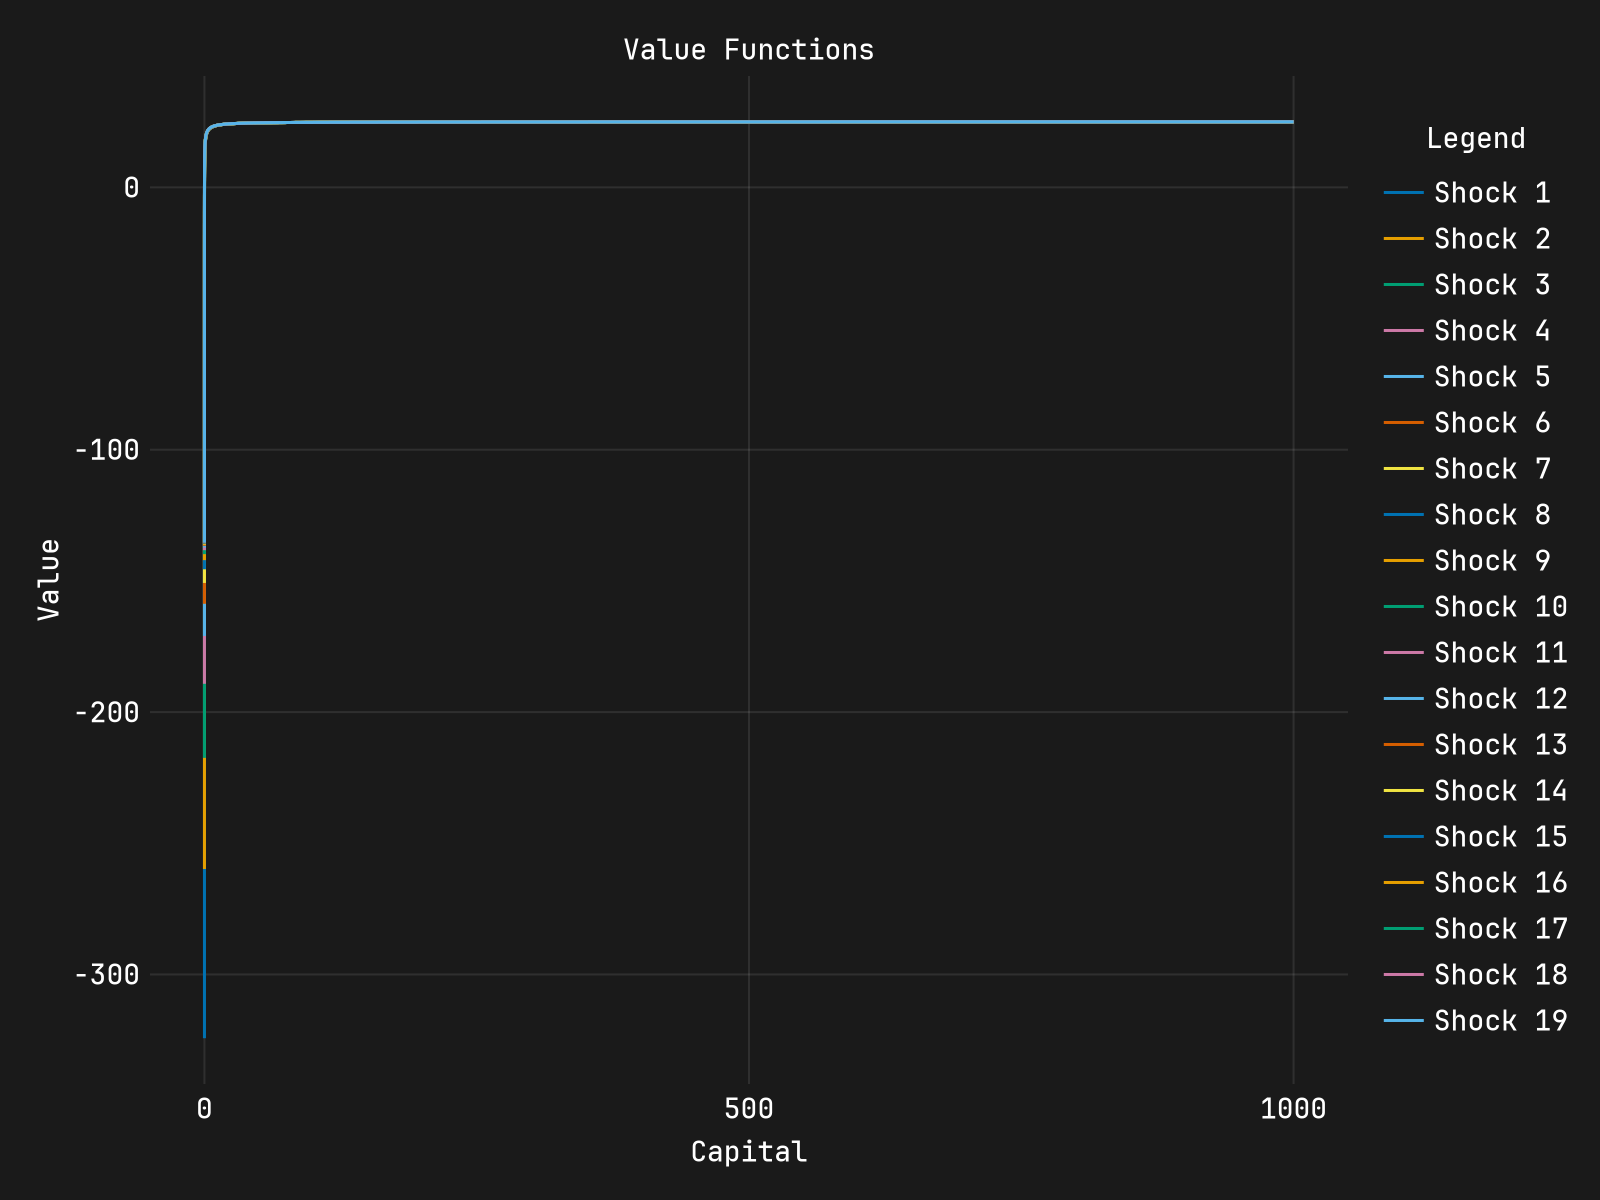

In [14]:
fig1 = Figure(size = (1600, 600))
ax1 = Axis(fig1[1, 1], 
        title = "Capital Policy",
        titlecolor = :white,
        titlefont = "JetBrains Mono",
        xlabel = "Capital Today",
        xlabelfont = "JetBrains Mono",
        xlabelcolor = :white,
        ylabel = "Capital Tomorrow", 
        ylabelfont = "JetBrains Mono",
        ylabelcolor = :white,
        xticklabelcolor = :white, 
        yticklabelcolor = :white,  
        xticklabelfont = "JetBrains Mono", 
        yticklabelfont = "JetBrains Mono")
for j in 1:model_EGM.nz
    lines!(ax1, model_EGM.kgrid, k_pol[:,j], label = "Shock $j")
end
lines!(ax1, model_EGM.kgrid, model_EGM.kgrid, label = "45 Deg Line", color = :white, linestyle = :dash)
legend = Legend(fig1[1,2], ax1, "Legend", orientation = :vertical, fontsize = 4, labelcolor = :white, labelfont = "JetBrains Mono", titlefont = "JetBrains Mono", titlecolor = :white)
ax2 = Axis(fig1[1, 3], 
        title = "Consumption Policy",
        titlecolor = :white,
        titlefont = "JetBrains Mono",
        xlabel = "Capital",
        xlabelfont = "JetBrains Mono",
        xlabelcolor = :white,
        ylabel = "Consumption", 
        ylabelfont = "JetBrains Mono",
        ylabelcolor = :white,
        xticklabelcolor = :white, 
        yticklabelcolor = :white,  
        xticklabelfont = "JetBrains Mono", 
        yticklabelfont = "JetBrains Mono")
for j in 1:model_EGM.nz
    lines!(ax2, model_EGM.kgrid, c_pol[:,j], label = "Shock $j")
end
lines!(ax2, model_EGM.kgrid, model_EGM.kgrid, label = "45 Deg Line", color = :white, linestyle = :dash)
legend = Legend(fig1[1,4], ax2, "Legend", orientation = :vertical, fontsize = 4, labelfont = "JetBrains Mono", labelcolor = :white, titlefont = "JetBrains Mono", titlecolor = :white)
display(fig1)

fig2 = Figure(size = (800, 600))
ax2 = Axis(fig2[1, 1], 
        title = "Value Functions",
        titlecolor = :white,
        titlefont = "JetBrains Mono",
        xlabel = "Capital",
        xlabelfont = "JetBrains Mono",
        xlabelcolor = :white,
        ylabel = "Value", 
        ylabelfont = "JetBrains Mono",
        ylabelcolor = :white,
        xticklabelcolor = :white, 
        yticklabelcolor = :white,  
        xticklabelfont = "JetBrains Mono", 
        yticklabelfont = "JetBrains Mono")
for j in 1:model_EGM.nz
    lines!(ax2, model_EGM.kgrid, v_out[:,j], label = "Shock $j")
end
legend = Legend(fig2[1,2], ax2, "Legend", orientation = :vertical, fontsize = 4, labelfont = "JetBrains Mono", labelcolor = :white, titlefont = "JetBrains Mono", titlecolor = :white)
fig2